In [49]:
from __future__ import print_function

import os
import sys
sys.path.append('/home/jogi/git/repository/smart_play_set')

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import fft, arange, fftpack

from utils.smart_utils import get_dir_path, tensor_to_pandas, load_hdf5_file
from utils.smart_utils import get_array_filenames
from preprocessing.process_data import get_data

from utils.plot_utils import plot_spectra_1axis, plot_spectra_3axis
from utils.plot_utils import plot_3axis_raw_signal_1, plot_3axis_raw_signal_compare
from utils.plot_utils import single_file_plots, load_file_to_pandas

from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation

%matplotlib inline 

(360, 3)


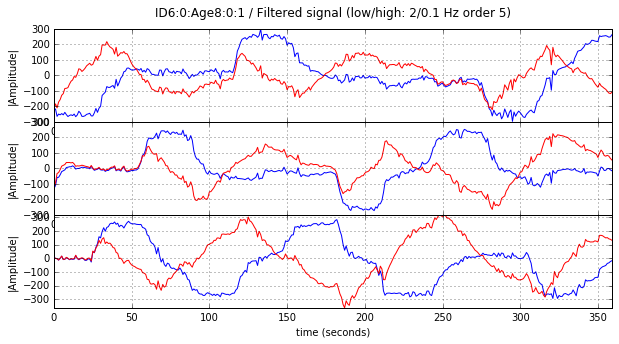

(360, 3)


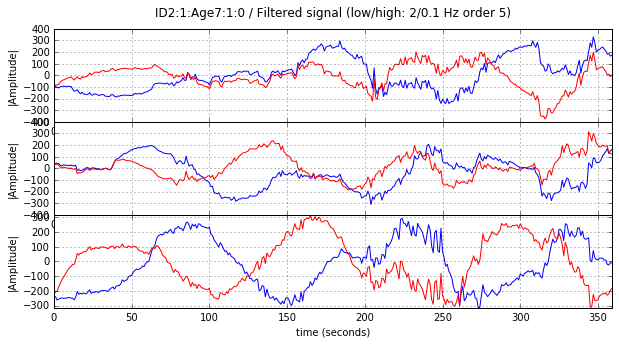

(360, 3)


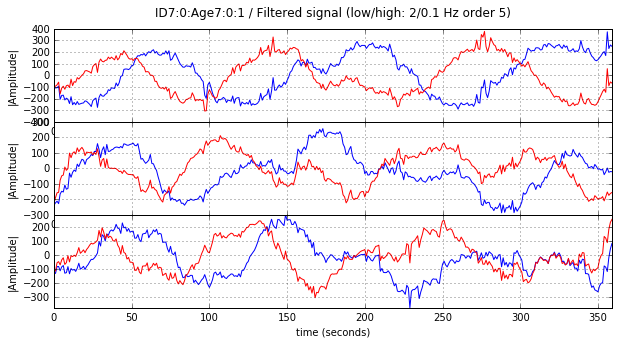

(360, 3)


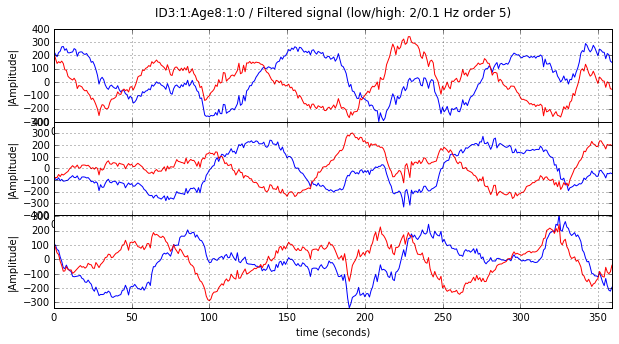

(360, 3)


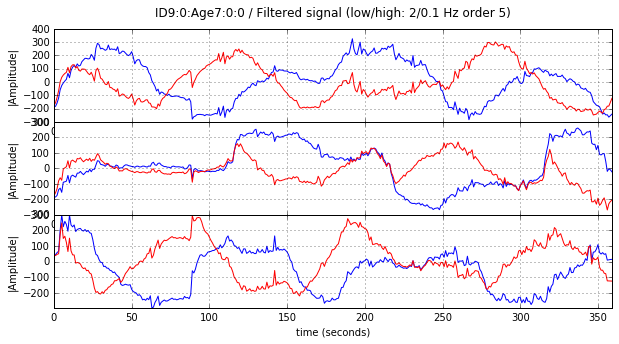

(360, 3)


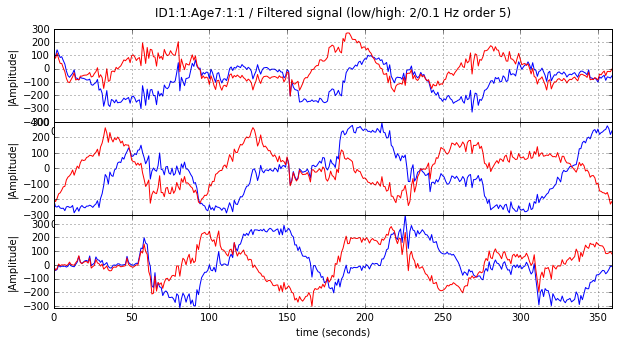

(360, 3)


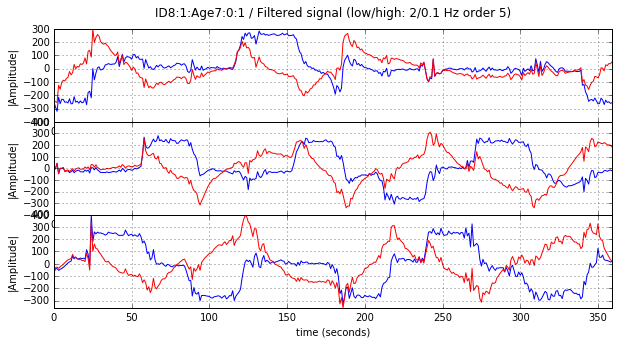

(360, 3)


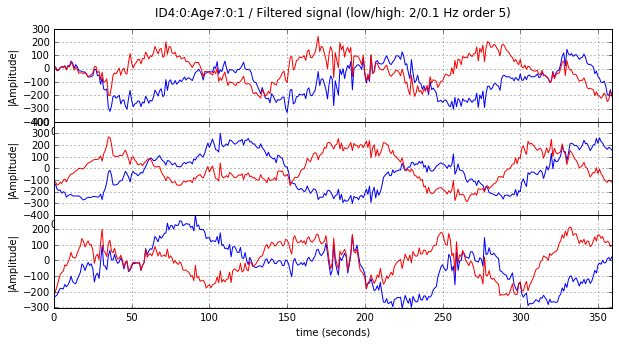

(360, 3)


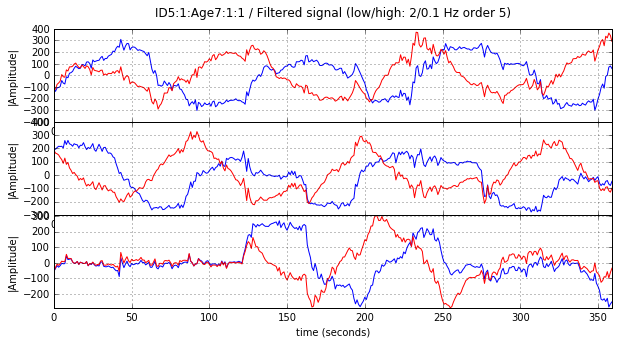

In [2]:
files = get_array_filenames('20160921', device='futurocube', game='roadrunner', sequence=1, file_ext='csv')
freq = 20   # 20 Hz
t_cufoff = 15*freq
exp_labels = []

for filename in files:
    labels = filename[filename.index('[') + 1:filename.index(']')] # .split(':')
    
    r_signal = (load_file_to_pandas("futurocube", "roadrunner", filename, abs_path=True)
         ).as_matrix()
    signal_fraction = r_signal[t_cufoff:t_cufoff+360, :]
    print(signal_fraction.shape)
    single_file_plots(signal_fraction, freq, lowcut=2, highcut=0.1, f_type='lowhigh', b_order=5, 
                      plot_type=1, width=10, height=5,
                      add_to_title=labels + " / ",
                      apply_w_func=False, skip_dc=True)


In [52]:
train_data, train_labels, dta_dict = get_data('20160921', force=False, apply_window_func=True, 
                                              extra_label="20hz_3axis_",
                                     calc_mag=True, f_type="lowhigh", lowcut=2, highcut=0.1, b_order=5)

INFO - Used data label 20160921_futurocube_roadrunner_20hz_3axis_s1
INFO Loading matrices from h5 file /home/jogi/git/repository/smart_play_set/data/futurocube/roadrunner/20160921_futurocube_roadrunner_20hz_3axis_s1.h5
('INFO - List of arrays in this file: \n', [u'feature_data', u'label_data'])
INFO - Loading data description from json.


In [23]:
# train_data, train_labels, dta_dict
print(dta_dict)

{u'window_size': 128, u'num_of_files': 9, u'features': [u'min', u'max', u'mean', u'std', u'median', u'dc', u'energy', u'power_spec_entropy'], u'MEAN_FILE_LENGTH': 2400, u'filter_specs': [2, 0.1, 5], u'filter': u'lowhigh', u'LEVEL_TIME_INTERVALS': [40, 80, 120], u'frequency': 20, u'id_sequence': [{u'CLASS': u'0', u'AGE': u'Age8', u'ID': u'ID6', u'HANDED': u'1', u'SEX': u'0'}, {u'CLASS': u'1', u'AGE': u'Age7', u'ID': u'ID2', u'HANDED': u'0', u'SEX': u'1'}, {u'CLASS': u'0', u'AGE': u'Age7', u'ID': u'ID7', u'HANDED': u'1', u'SEX': u'0'}, {u'CLASS': u'1', u'AGE': u'Age8', u'ID': u'ID3', u'HANDED': u'0', u'SEX': u'1'}, {u'CLASS': u'0', u'AGE': u'Age7', u'ID': u'ID9', u'HANDED': u'0', u'SEX': u'0'}, {u'CLASS': u'1', u'AGE': u'Age7', u'ID': u'ID1', u'HANDED': u'1', u'SEX': u'1'}, {u'CLASS': u'1', u'AGE': u'Age7', u'ID': u'ID8', u'HANDED': u'1', u'SEX': u'0'}, {u'CLASS': u'0', u'AGE': u'Age7', u'ID': u'ID4', u'HANDED': u'1', u'SEX': u'0'}, {u'CLASS': u'1', u'AGE': u'Age7', u'ID': u'ID5', u'HAND

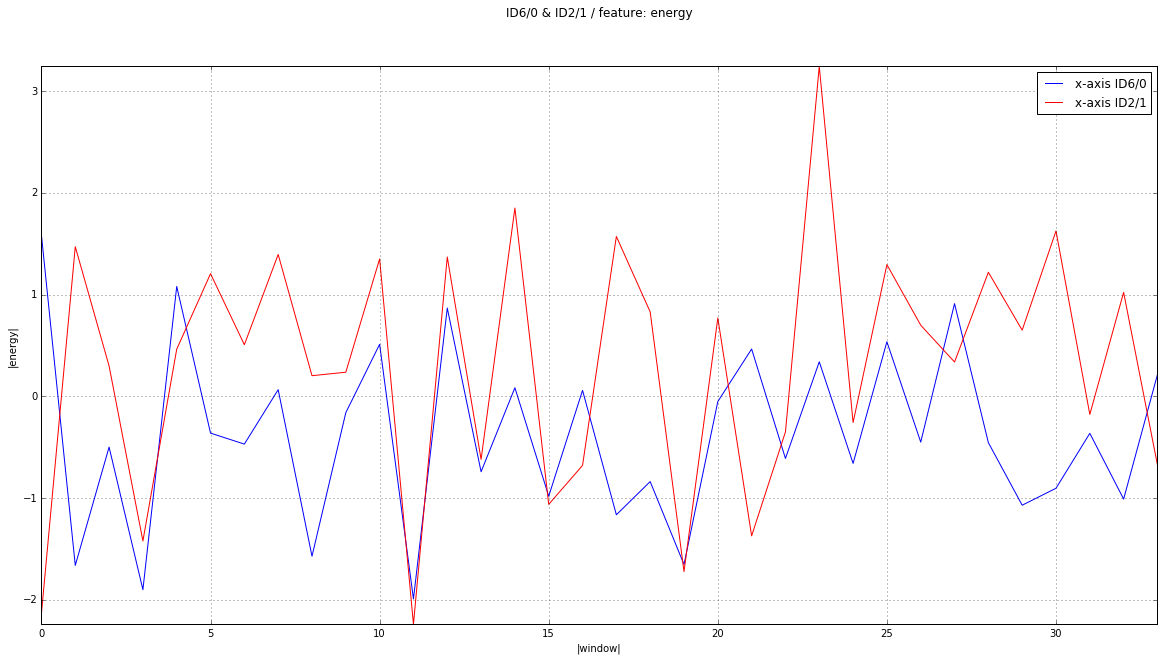

In [36]:
def plot_one_feature(data1, label1, f_index, features, data2=None, label2="", width=20, height=10, 
                           p_legend=False, xyz_axis=True):
    
    feature = features[f_index]
    data1 = np.reshape(data1[:, f_index, :], (data1.shape[0], data1.shape[2]))
    if data2 is not None:
        data2 = np.reshape(data2[:, f_index, :], (data2.shape[0], data2.shape[2]))
        p_title = label1 + " & " + label2 + " / feature: " + feature
    else:
        p_title = label1 + " / feature: " + feature
        
    t = np.arange(data1.shape[0])
    y_label = "|" + feature + "|"
    x_label = "|window|"
    
    plt.figure(figsize=(width, height))
    if xyz_axis:
        ax1 = plt.subplot(3, 1, 1)
    else:
        ax1 = plt.subplot(1, 1, 1)
        
    plt.title(p_title, y=1.08)

    plt.plot(t, data1[:, 0], label='x-axis ' + label1)
    if data2 is not None:
        plt.plot(t, data2[:, 0], label='x-axis ' + label2, color='r')
    plt.xlabel(x_label)
    plt.grid(True)
    plt.ylabel(y_label)
    if p_legend:
        plt.legend(loc="best")
    
    if xyz_axis:
        plt.subplot(3, 1, 2, sharex=ax1)
        plt.plot(t, data1[:, 1], label='y-axis ' + label1)
        if data2 is not None:
            plt.plot(t, data2[:, 1], label='y-axis ' + label2, color='r')
        plt.xlabel(x_label)
        plt.grid(True)
        plt.ylabel(y_label)
        if p_legend:
            plt.legend(loc="best")

        plt.subplot(3, 1, 3, sharex=ax1)
        plt.plot(t, data1[:, 2], label='z-axis ' + label1)
        if data2 is not None:
            plt.plot(t, data2[:, 2], label='z-axis ' + label2, color='r')
        plt.xlabel(x_label)
        plt.grid(True)
        plt.ylabel(y_label)
        if p_legend:
            plt.legend(loc="best")

    plt.axis('tight')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()


num_of_windows = int(dta_dict["num_of_windows"])
feature_list = dta_dict["features"]
label_dicts = dta_dict["id_sequence"]
dta1 = train_data[0:num_of_windows, :, :]
label1 = label_dicts[0]["ID"] + "/" + label_dicts[0]["CLASS"] 
label2 = label_dicts[1]["ID"] + "/" + label_dicts[1]["CLASS"]
dta2 = train_data[num_of_windows:num_of_windows+num_of_windows, :, :]
plot_one_feature(dta1, label1, data2=dta2, label2=label2, features=feature_list, f_index=6,  
                       p_legend=True, xyz_axis=False)

In [54]:
# for cross validation train data has to have 2 dim tensor
train_data_r = np.reshape(train_data, (train_data.shape[0], train_data.shape[1] * train_data.shape[2]))
# for cross validation train labels has to have 1 dim tensor
train_labels_r = np.reshape(train_labels, (train_labels.shape[0]))
print(train_data_r.shape, train_labels_r.shape)
gnb = GaussianNB()
# y_pred = gnb.fit(train_data_r, train_labels_r).predict(train_data_r)
# print("Number of mislabeled points out of a total %d points : %d" % 
#                       (train_data_r.shape[0],(train_labels_r != y_pred).sum()))

scores = cross_validation.cross_val_score(gnb, train_data_r, train_labels_r, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

(306, 24) (306,)
Accuracy: 0.50 (+/- 0.08)


In [43]:
clf = svm.SVC(kernel='rbf', C=1)
scores = cross_validation.cross_val_score(clf, train_data_r, train_labels_r, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.66 (+/- 0.22)


In [46]:
clf = tree.DecisionTreeClassifier()
scores = cross_validation.cross_val_score(clf, train_data_r, train_labels_r, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.61 (+/- 0.06)


In [48]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
scores = cross_validation.cross_val_score(clf, train_data_r, train_labels_r, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.60 (+/- 0.19)


In [51]:
xgb = XGBClassifier(learning_rate=0.1, n_estimators=400, max_depth=4, min_child_weight=2, gamma=0,
                         subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', nthread=4,
                         scale_pos_weight=1, seed=27)
scores = cross_validation.cross_val_score(clf, train_data_r, train_labels_r, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.60 (+/- 0.19)
